## Phase calculation: simple example ##

Using gradient descent with momentum

Brute force approach: C = squared-error, with step size renormalisation.

*Sam's experiments notebook - currently half-baked!*

### Preamble; loading target and weighting arrays ###

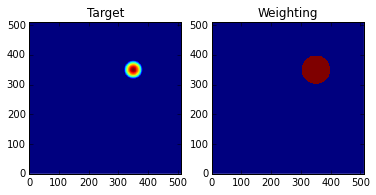

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import theano

%matplotlib inline


# decide what target you want:
targetdir = 'initialisation/example_power2_512_(350,350)_64/'
targetname = os.path.join(targetdir, 'target.dat')
# decide what weighting arrays to use:
weightingdir = os.path.join(targetdir, 'weighting_border_16_noise_1e-06/')
weightingname = os.path.join(weightingdir, 'weight.dat')
weightingASname = os.path.join(weightingdir, 'weight_as.dat')


target = np.loadtxt(targetname)
weighting = np.loadtxt(weightingname)
weighting_as = np.loadtxt(weightingASname)

N = target.shape[0]/2  # size of SLM is NxN (assuming that padding has doubled size here)

plot_args = {'extent':[0, 2*N, 0, 2*N],
             'interpolation':'None',
             'origin': 'lower'}

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(target, vmin=0, vmax=1, **plot_args)
axes[0].set_title('Target')
axes[1].imshow(weighting, vmin=0, vmax=1, **plot_args)
axes[1].set_title('Weighting');

In [10]:
# Initialise SLM optimisation class:
import theano
import theano.tensor as T

# the code to set up the computation graph transforming the phases
# into an intensity field lives in the slmOptimisation class.
from slm import slmOptimisation

# initialise the phase:
def initial_phase(N):
    """ Return a randomised phase array over [0, 2pi]
    """
    return np.random.uniform(low=0, high=2*np.pi, size=(N,N)).astype(theano.config.floatX)

init_phi = initial_phase(N)

# for this example, the profile $S_{nm}$ is uniform.
s_profile = np.ones_like(init_phi, dtype=complex)  # NB in general s_profile may be complex.

slmOpt = slmOptimisation(target, init_phi, s_profile, A0=1.0/1000) # fudge factor! Need to stabilise this...

This is the crucial part, where we define the __cost__ function. Here we simply take the difference between the reconstruction and the target, square and sum.  Differentiation of this cost function happens automatically further downstream.
$$ C = \sum_{nm} (T_{nm} - |E^{out}_{nm}|^2)^2 $$

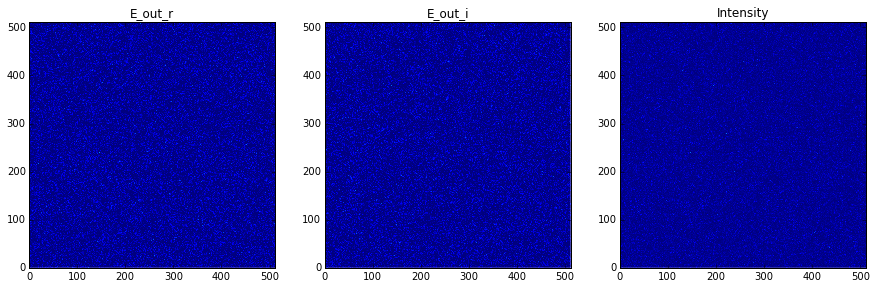

In [11]:
# we now define a cost function to use, squared error for now.
cost = T.sum(T.pow((slmOpt.E_out_2 - target)*weighting, 4))

# visualise the output given the initial phi field
f_E_out = slmOpt.get_E_out()   # these return functions to evaluate the output
f_E2_out = slmOpt.get_intensity()

E_out = f_E_out()              # actually calculate the SLM output
E2_out = f_E2_out()

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('E_out_r')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('E_out_i')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

### Stage 2 ###

In [12]:
import pandas as pd
from pandas import DataFrame

l_count = []
l_cost_SE = []
l_cost_AS = []
nn = 0  # global step-counting index

In [19]:
# new cost function:
cost_SE   = T.sum(T.pow((slmOpt.E_out_2 - target)*weighting, 2))
cost_QE   = T.sum(T.pow((slmOpt.E_out_2 - target)*weighting, 4))
cost_AS_x =  T.sum(T.pow(slmOpt.E_out_2[0:2*N-1,:]-slmOpt.E_out_2[1:2*N,:], 2) * 20*weighting_as[0:2*N-1,:])
cost_AS_y =  T.sum(T.pow(  slmOpt.E_out_2[:,0:2*N-1]-slmOpt.E_out_2[:,1:2*N], 2) * 20*weighting_as[:,0:2*N-1])

cost = cost_SE #+ cost_AS_x + cost_AS_y
grad = T.grad(cost, wrt=slmOpt.phi)

l_rate = 0.1   # 'learning rate'
momentum = 0.95 # momentum decay
updates = ((slmOpt.phi, slmOpt.phi - l_rate * slmOpt.phi_rate),
           (slmOpt.phi_rate, momentum*slmOpt.phi_rate + (1.-momentum)*grad))

print "Compiling update function..."
update = theano.function([], 
                         cost, 
                         updates=updates,
                         on_unused_input='warn')
print "...done"

C = update()

f_cost_SE = theano.function([], cost_SE)
f_cost_AS = theano.function([], cost_AS_x + cost_AS_y)

f_phi_updates = theano.function([], l_rate*slmOpt.phi_rate)
# phi_rate_hist = 1.0  # best if it's rather high.

Compiling update function...
...done


In [ ]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,10))

# make plots
E_out = f_E_out()
E2_out = f_E2_out()

N_steps = 200000
update_rate_target = 1e-5
phi_rate_avg = 0.0
print 'Initial C: {}'.format(C)
last_C = C
n = 0
for n in range(N_steps):
    C = update()
    nn += 1
    if np.mod(n, 10) == 0:
        phi_rate_avg += np.mean(np.abs(f_phi_updates())) * 10./250
    if np.mod(n, 1000) == 0:
        np.savetxt('data/' + str(nn) + '.dat', slmOpt.phi.get_value())
    if np.mod(n, 250) == 0:
        c_SE = float(f_cost_SE())
        c_AS = float(f_cost_AS())
        l_cost_SE.append(c_SE)
        l_cost_AS.append(c_AS)
        l_count.append(nn)
        print '{step:d} Cost (SE):{cost_SE:.2e}   Cost (AS):{cost_AS:.2e}   Steps: mean:{update_step:.2e} max:{max_update_step:.2e}   l_rate:{l_rate:.2e}'.format(
            step=nn,
            cost_SE=c_SE,
            cost_AS=c_AS,
            update_step=np.mean(np.abs(f_phi_updates())),
            max_update_step=np.max(np.abs(f_phi_updates())),
            l_rate=l_rate
        )
        # save the intensity plot:
        # make plots
        E_out = f_E_out()
        E2_out = f_E2_out()
        ax.imshow(E2_out[300:400,300:400], vmin=0, vmax=1, **plot_args)
        ax.set_title('Intensity');
        ax2.imshow(E_out[0][300:400,300:400], vmin=-1, vmax=1, **plot_args)
        ax2.set_title('Re(E)');
        fig_name = os.path.join('plots', str(nn) + '.png')
        plt.savefig(fig_name)
        # print '{:d} {:.2e}'.format(n, float(C))
        
        # also renormalise the update rate:
        l_rate = np.min([update_rate_target / phi_rate_avg, 1.5*l_rate])  # can go up by 50% at the most.
        phi_rate_avg = 0.0 # reset
        updates = ((slmOpt.phi, slmOpt.phi - l_rate * slmOpt.phi_rate),
                   (slmOpt.phi_rate, momentum*slmOpt.phi_rate + (1.-momentum)*grad))
        update = theano.function([], 
                                 cost, 
                                 updates=updates,
                                 on_unused_input='warn')

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=-3, vmax=3, **plot_args)
ax1a.set_title('Re(E)')
ax1b.imshow(E_out[1], vmin=-3, vmax=3, **plot_args)
ax1b.set_title('Im(E)')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

Initial C: 58.14630568
10002 Cost (SE):5.81e+01   Cost (AS):4.19e+03   Steps: mean:2.97e-05 max:4.88e-04   l_rate:3.20e-01
10252 Cost (SE):5.70e+01   Cost (AS):4.15e+03   Steps: mean:2.63e-05 max:3.95e-04   l_rate:4.80e-01
10502 Cost (SE):5.64e+01   Cost (AS):4.13e+03   Steps: mean:2.59e-05 max:3.53e-04   l_rate:3.58e-01
10752 Cost (SE):5.55e+01   Cost (AS):4.09e+03   Steps: mean:2.85e-05 max:3.55e-04   l_rate:3.87e-01

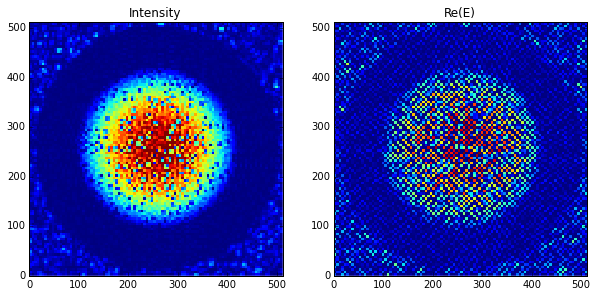

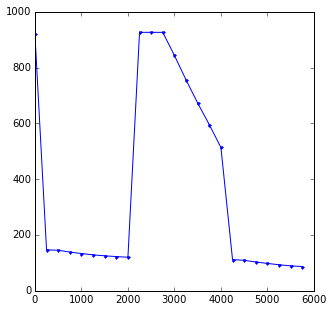

In [21]:
E_out = f_E_out()
E2_out = f_E2_out()

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,10))
ax.imshow(E2_out[300:400,300:400], vmin=0, vmax=1, **plot_args)
ax.set_title('Intensity');
ax2.imshow(E_out[0][300:400,300:400], vmin=0, vmax=1, **plot_args)
ax2.set_title('Re(E)');

df = DataFrame({'idx': l_count, 'Cost (SE)': l_cost_SE, 'Cost (AS)': l_cost_AS})
# df.plot(marker='.')
fig2 = plt.figure(figsize=(5,5))
plt.gca().plot(df['idx'], df['Cost (SE)'], '.-')

In [22]:
print 'Mean update: {}'.format(np.mean(np.abs(f_phi_updates())))

phi_save = slmOpt.phi.get_value()
print phi_save
np.savetxt('phi.dat', phi_save)

Mean update: 9.58040465695e-05
[[  5.98389054e+09  -2.71399113e+09   7.38181647e+09 ...,  -1.48598954e+09
    1.21556788e+09   1.90298998e+09]
 [  7.69890684e+09   1.68129596e+08  -7.36077204e+09 ...,  -5.04386895e+08
   -7.68794175e+09   7.24663182e+09]
 [  3.98692495e+09   2.42383594e+09   6.99695632e+09 ...,  -1.40415657e+08
   -3.51080608e+09  -4.57848340e+09]
 ..., 
 [ -1.27905974e+08  -2.15259345e+09   6.78833175e+09 ...,  -2.34166464e+08
    8.00414388e+08  -2.78153069e+07]
 [  1.37600957e+09   4.71834327e+09   4.44664430e+08 ...,   7.30513478e+09
   -6.40703085e+09  -5.64020710e+06]
 [ -7.25466958e+09  -7.43861336e+09  -2.05331013e+08 ...,   4.30803459e+08
    2.33098792e+09   3.13821160e+09]]


In [8]:
phi_save = np.loadtxt('data/8501.dat')
slmOpt.phi.set_value(phi_save)
slmOpt.phi_rate.set_value(np.zeros_like(phi_save, dtype=theano.config.floatX))

In [15]:
l_rate

0.51741170361234867

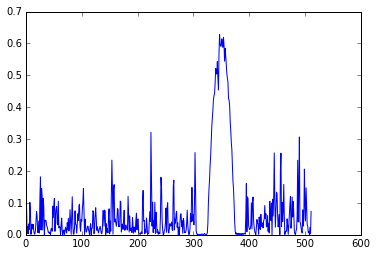

In [19]:
plt.plot(E2_out[:,330])

In [26]:
slmOpt.phi.set_value( np.mod(slmOpt.phi.get_value(), 2*np.pi))